# Bayesian workflow

Leveraging Bayesian inference for addressing real-world problems requires from the modeller not only to be proficient in statsitics, have domain expertise and programming skills, but also a deep understanding of the decision-making process while analysing data. Apart from inference, the workflow includes iterative model building, model checking, validation and troubleshooting of computational problems, model understanding, and model comparison.

Recall the Bayes formula:

 $$p(\theta|y) = \frac{p(y | \theta) p(\theta)}{p(y)},$$

- $p(\theta)$ is the *prior* distribution, i.e. what is known *a priori*
- $p(y|\theta)$ is the *likelihood*, i.e. probability of observing the data given parameters $\theta$
- $p(\theta|y)$ is the *posterior* distribution, i.e. the distribution of parameters of interest after data were observed

Seemingly, the Bayes rule looks very simple:

$$\underbrace{p(\theta|y)}_\text{posterior} \propto \underbrace{p(y | \theta)}_{\text{likelihood}}  \underbrace{p(\theta)}_{\text{prior}}$$

What could possibly go wrong about it in practice?

A lot can go wrong! And in case things go wrong, decisions need to be made sequentially about model building and improvement. That is why we need the Bayesian workflow.

## Principles of Bayesian workflow

Workflows exist in a variety of disciplines where they define what is a 'good practice'.


## Box's loop

In the 1960's, the statistician Box formulated the notion of a loop to understand the nature of the scientific method. This loop is called Box's loop by Blei et. al. (2014):

<center>
<div>
<img src="assets/boxes_loop.png" width="500"/>
</div>
</center>

## Modern Bayesian workflow

A systematic review of the steps within the modern Bayesian workflow, described in Gelman et al. (2020):

<center>
<div>
<img src="assets/bayes_workflow.png" width="500"/>
</div>
</center>


## Prior predictive checks

<font color='orange'>Prior predictive checking</font> consists in simulating data from the priors:

- visualize priors (especially after transformation),

- this shows the range of data compatible with the model,

- it helps understand the adequacy of the chosen priors, as it is often easier to elicit expert knowledge on measureable quantities of interest rather than abstract parameter values.


## Iterative model building

A possible realisation of the Bayeisan workflow loop:

- Understand the <font color='orange'>domain</font> and problem,

- Formulate the model <font color='orange'>mathematically</font>,

- Implement model, test, <font color='orange'>debug</font>,

- <font color='orange'>debug, debug, debug.</font>

- Perform <font color='orange'>prior predictive</font>, check,

- Fit the model,

- Assess <font color='orange'>convergence diagnostics</font>,

- Perform <font color='orange'>posterior predictive</font> check,  

- Improve the model <font color='orange'>iteratively</font>: from baseline to complex and computationally efficient models.

## Examples


In [39]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import hpdi

import jax
import jax.numpy as jnp
from jax import random

import arviz as az
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import pandas as pd


## Coin tossing 

### Data

In [12]:
n = 100    # number of trials
h = 61     # number of successes
alpha = 2  # hyperparameters
beta = 2

niter = 1000

### Model

In [13]:
def model(n, alpha=2, beta=2, h=None):

    # prior on the probability of success p
    p = numpyro.sample('p', dist.Beta(alpha, beta))

    # likelihood - notice the `obs=h` part
    # p is the probabiity of success,
    # n is the total number of experiments
    # h is the number of successes
    numpyro.sample('obs', dist.Binomial(n, p), obs=h)

### Prior Predictive check

A <font color='purple'>prior predictive check</font> is a method used in Bayesian statistics to assess the <font color='orange'>compatibility of a chosen prior distribution</font> with the observed data by simulating data from the prior and comparing it to the actual data - an overlooked but golden tool!

In [14]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# use the Predictive class to generate predictions.
# Notice that we are not passing observation `h` as data.
# Since we have set `h=None`, this allows the model to make predictions of `h`
# when data for it is not provided.
prior_predictive = Predictive(model, num_samples=1000)
prior_predictions = prior_predictive(rng_key_, n)

In [15]:
# we have generated samples for two variables
prior_predictions.keys()

dict_keys(['obs', 'p'])

In [16]:
# extract samples for variable 'p'
pred_obs = prior_predictions['p']

# compute its summary statistics for the samples of `p`
mean_prior_pred = jnp.mean(pred_obs, axis=0)
hpdi_prior_pred = hpdi(pred_obs, 0.89)

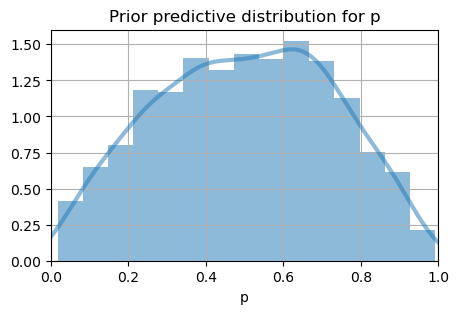

In [17]:
fig = plt.figure(dpi=100, figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(pred_obs, bins=15, density=True, alpha=0.5)
x = jnp.linspace(0, 1, 3000)
kde = gaussian_kde(pred_obs)
ax.plot(x, kde(x), color='C0', lw=3, alpha=0.5)
ax.set_xlabel('p')
ax.set_title('Prior predictive distribution for p')
ax.set_xlim(0, 1)
ax.grid(0.3)
plt.show()

### Inference

Using the same routine as we did for prior redictive, we can perform inference by using the observed data.

In [21]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# specify inference algorithm
kernel = NUTS(model)

# define number of samples and number chains
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)

/var/folders/q3/n2z18__9281b8xfhctcpxfsr0000gn/T/ipykernel_78687/1124365268.py:8: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)


In [22]:
#run MCMC
mcmc.run(rng_key_, n=n, h=h)

sample: 100%|██████████| 3000/3000 [00:01<00:00, 1762.60it/s, 3 steps of size 9.60e-01. acc. prob=0.93]


In [26]:
# exatract samples of parameter p
p_samples = mcmc.get_samples()
p_posterior_samples = p_samples['p']

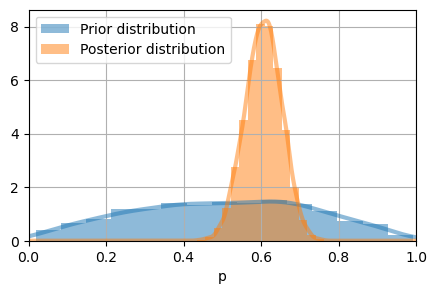

In [27]:
fig = plt.figure(dpi=100, figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(pred_obs, bins=15, density=True, alpha=0.5, label = "Prior distribution")
ax.hist(p_posterior_samples, bins=15, density=True, alpha=0.5, label = "Posterior distribution")
x = jnp.linspace(0, 1, 3000)
kde = gaussian_kde(pred_obs)
ax.plot(x, kde(x), color='C0', lw=3, alpha=0.5)
kde = gaussian_kde(p_posterior_samples)
ax.plot(x, kde(x), color='C1', lw=3, alpha=0.5)
ax.set_xlabel('p')
ax.set_xlim(0, 1)
ax.grid(0.3)
plt.legend()
plt.show()

### Check convergence

We now have obtained the samples from MCMC. How can we assess whether we can trust the results? Convergence diganostics survey this purpose. Beyond $\hat{R}$, we can also visually inspect traceplots. Traceplots are simply sample values plotted against the iteration number. We want those traceplots to be stationary, i.e. they should look like a "hairy carterpillar".

In [29]:
# inpect summary
# pring summary and look at R-hat
# r_hat is a dignostic comparing within chain variation to between chan variation.
# It is an importnat convergene diagnostic, and we want its valye to be close to 1
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         p      0.61      0.05      0.61      0.53      0.69   3084.07      1.00

Number of divergences: 0


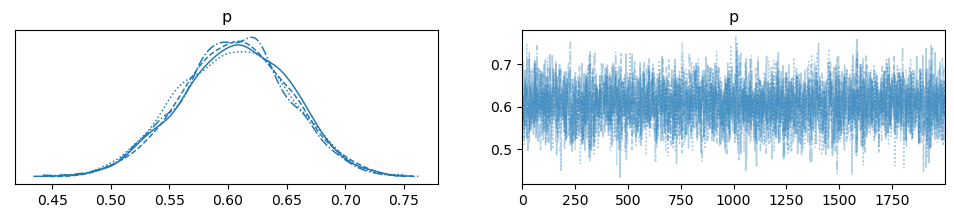

In [31]:
# plot posterior distribution and traceplots
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

### Posterior predictive distribution

The <font color='purple'>posterior predictive</font> distribution is a concept in Bayesian statistics that combines the information from both the observed data and the posterior distribution of model parameters to <font color='orange'>generate predictions for new, unseen data</font> .

We can use the obtained samples obtained at the previous step to generate posterior predictive desitribution on the outcome.

In [32]:
# using the same 'Predictive' class,
# but now specifying also `p_samples`
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, p_samples)
posterior_predictions = predictive(rng_key_, n=n)

In [34]:
# extract prediction and calculate summary statistics
post_obs = posterior_predictions['obs']
mean_post_pred = jnp.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.9)

In [35]:
# what is the mean number of successes?
mean_post_pred

Array(60.54975, dtype=float32)

In [36]:
# what is the unceratinty around this mean?
hpdi_post_pred

array([49, 71], dtype=int32)

**Group task:** change the hyperparamaters of the model. How are they changing the results?

## Bayesian Linear regression

Now that we know how to use NumPyro. Let us build an example using larger amounts of data and build a Bayesian Linear Regression model. It is the same Linear Regression model you are familiar with, but here all of the parameters are estimated in the Bayesian way.

In [40]:
!wget -O Howell1.csv https://raw.githubusercontent.com/deep-learning-indaba/indaba-pracs-2023/main/data/Howell1.csv

df = pd.read_csv('Howell1.csv', sep=";")
df.head()

--2024-02-03 15:09:18--  https://raw.githubusercontent.com/deep-learning-indaba/indaba-pracs-2023/main/data/Howell1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12205 (12K) [text/plain]
Saving to: ‘Howell1.csv’

Howell1.csv         100%[===================>]  11.92K  --.-KB/s    in 0.002s  

2024-02-03 15:09:18 (5.31 MB/s) - ‘Howell1.csv’ saved [12205/12205]



,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [41]:
# observed data
weight = df.weight.values
height = df.height.values

Let us define some test data for the variable `weight`. For these datapoints we will make predictions.

In [43]:
# data to make predictions for
weight_pred = jnp.array([45, 40, 65, 31, 53])

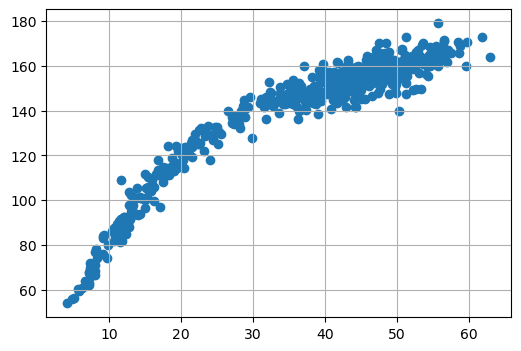

In [44]:
# plot the data
plt.figure(figsize=(6, 4))
plt.scatter(x='weight', y='height', data=df)
plt.grid(0.3)

The linear regression model will have the form

$$y \sim N(\mu, \sigma^2),\\
\mu = b_0 + b_1 x.$$

Here $y$ is the data we want to predict, $x$ is the predictor, $b_0$ is the bias (intercept), $b_1$ is the slope (weight) and $\sigma^2$ is variance.

**Group task:** Discuss which priors would be reasonable for the parameters $b_0$, $b_1$, $\sigma$.

In [45]:
# model
def model(weight=None, height=None):
    # priors
    b0 = numpyro.sample('b0', dist.Normal(120,50))
    b1 = numpyro.sample('b1', dist.Normal(0,1))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10.))

    # deterministic transformation
    mu = b0 + b1 * weight

    # likelihood: notice `obs=height`
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=height)

In [46]:
# prior predictive
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model, num_samples=100)
prior_predictions = prior_predictive(rng_key_, weight)

In [47]:
prior_predictions.keys()

dict_keys(['b0', 'b1', 'obs', 'sigma'])

In [49]:
pred_obs = prior_predictions['obs']
mean_prior_pred = jnp.mean(pred_obs, axis=0)
hpdi_prior_pred = hpdi(pred_obs, 0.89)

In [52]:
def plot_regression(x, y_mean, y_hpdi, height, ttl='Predictions with 89% CI)'):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    weight = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    ht = height[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(weight, mean)
    ax.plot(weight, ht, 'o')
    ax.fill_between(weight, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    ax.set(xlabel='weight', ylabel='height', title=ttl);
    return ax

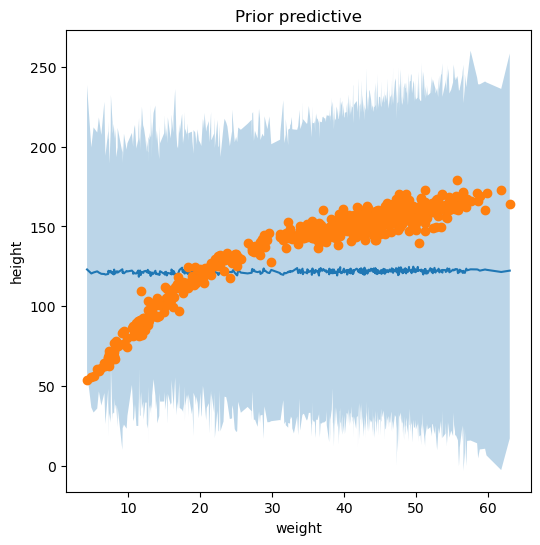

In [53]:
ax = plot_regression(weight, mean_prior_pred, hpdi_prior_pred, height, ttl="Prior predictive")

In [54]:
# Inference
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)
mcmc.run(rng_key_, weight=weight, height=height)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

/var/folders/q3/n2z18__9281b8xfhctcpxfsr0000gn/T/ipykernel_78687/3808916169.py:7: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)
sample: 100%|██████████| 3000/3000 [00:01<00:00, 1707.66it/s, 15 steps of size 2.61e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0     75.49      1.07     75.48     73.72     77.26   2608.93      1.00
        b1      1.76      0.03      1.76      1.72      1.81   2692.35      1.00
     sigma      9.37      0.29      9.36      8.86      9.82   3778.49      1.00

Number of divergences: 0


In [ ]:
# Check convergence
mcmc.print_summary()
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

In [ ]:
# Posterior predictive
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
posterior_predictions = predictive(rng_key_, weight=weight)
post_obs = posterior_predictions['obs']

mean_post_pred = jnp.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.9)

ax = plot_regression(weight, mean_post_pred, hpdi_post_pred, height, ttl="Posterior predictive")
ax.set(xlabel='weight (scaled)', ylabel='height (scaled)');

In [ ]:
# predict for new data
predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_, weight=weight_pred)['obs']

mean_pred = jnp.mean(predictions, axis=0)
hpdi_pred = hpdi(predictions, 0.89)

d = {'weight_pred': weight_pred, 'mean_pred': mean_pred, 'lower': hpdi_pred[0,], 'upper': hpdi_pred[1,]}
df_res = pd.DataFrame(data=d)
df_res.head()

**Group task:** modify the model in a way that it fits better.

**Hint:** apply a transformations to input data, e.g. a polynomial.

In [61]:
def model_polyn_2(weight, height=None):
    weight_std = (weight - jnp.mean(weight))/jnp.std(weight)
    weight_std_2 = weight_std ** 2

    # priors
    b0 = numpyro.sample('b0', dist.Normal(160,20))
    b1 = numpyro.sample('b1', dist.Normal(0,5))
    b2 = numpyro.sample('b2', dist.Normal(0,5))
    sigma = numpyro.sample('sigma', dist.HalfNormal(50.))

    mu = b0 + b1 * weight_std + b2 * weight_std_2

    # likelihood
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=height)

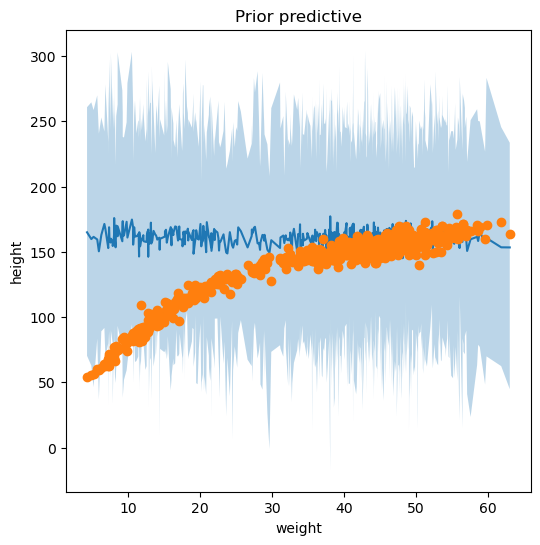

In [62]:
# prior predictive
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model_polyn_2, num_samples=100)
prior_predictions = prior_predictive(rng_key_, weight=weight)
pred_obs = prior_predictions['obs']
mean_prior_pred = jnp.mean(pred_obs, axis=0)
hpdi_prior_pred = hpdi(pred_obs, 0.89)
ax = plot_regression(weight, mean_prior_pred, hpdi_prior_pred, height, ttl="Prior predictive")

In [63]:
# inference
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
kernel = NUTS(model_polyn_2)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key_, weight=weight, height=height)
mcmc.print_summary()
samples_3= mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:05<00:00, 503.99it/s, 7 steps of size 4.47e-01. acc. prob=0.94]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0    146.68      0.39    146.68    146.02    147.28   1052.28      1.00
        b1     21.33      0.29     21.33     20.83     21.80   1296.63      1.00
        b2     -8.42      0.29     -8.41     -8.91     -7.95   1013.74      1.00
     sigma      5.78      0.17      5.77      5.51      6.05   1494.65      1.00

Number of divergences: 0


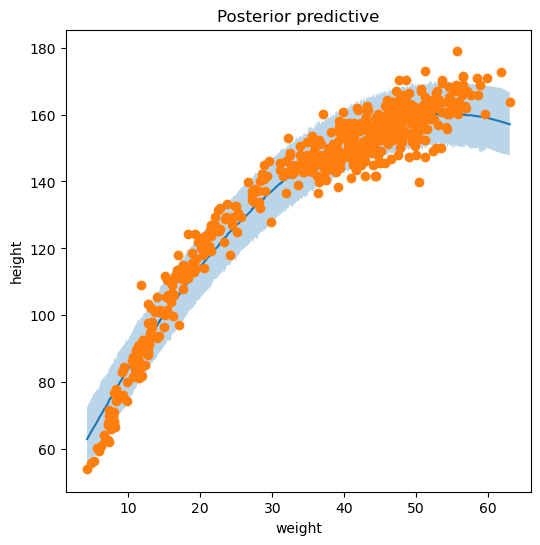

In [65]:
# posterior predictive
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model_polyn_2, samples_3)
posterior_predictions = predictive(rng_key_, weight=weight)
post_obs = posterior_predictions['obs']
mean_post_pred = jnp.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.9)

ax = plot_regression(weight, mean_post_pred, hpdi_post_pred, height, ttl="Posterior predictive")
ax.set(xlabel='weight', ylabel='height');